Introduction
複数の時系列データの時系列予測を行います。

各種ライブラリの取得

In [8]:
!pip install statsmodels

In [1]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
import time
from contextlib import contextmanager
import tensorflow as tf
from keras.callbacks import TensorBoard
from pathlib import Path

plt.style.use('ggplot')

時間計測のための関数

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

気温データの取得
直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

前処理
データを前処理をして学習が容易な形にします。まずはデータを取得し対数化します。これはガスの生産量はデータのスケールが1646から約6000近くまであるのに対し、気温変化は-0.8から26.3とデータ間の差が大きいためです。

データをリンク先から読み込みます。
データのスケールが異なるので両データを対数にスケーリングします。
0の部分は計算できないので + 1の処理が入ります。
それでも発生する計算できない値はnanになるため0に置き換えます。

In [3]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

In [4]:
max(wave_data["Temp"].values)

26.3

In [28]:
wave_data

,Date,Temp
463,1981.024658,21.8
7,1981.027397,20.0
326,1981.030137,16.2
1,1981.049315,24.8
124,1981.063014,14.4
...,...,...
166,1990.884932,9.9
226,1990.912329,14.7
205,1990.928767,20.5
420,1990.964384,17.2


In [5]:
production_of_gas_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/monthly-production-of-gas-in-aus-train.csv', header=None, names=["Date", "production-of-gas"])
production_of_gas_data = production_of_gas_data.sort_values(by=['Date'])

In [7]:
production_of_gas_data

,Date,production-of-gas
28,1956.087671,1646.0
233,1956.167123,1794.0
137,1956.252055,1878.0
215,1956.419178,2321.0
147,1956.501370,2468.0
...,...,...
94,1995.087671,41471.0
19,1995.164384,46287.0
124,1995.249315,49013.0
218,1995.331507,56624.0


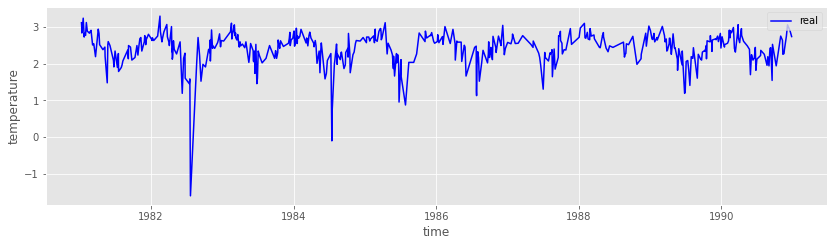

In [6]:
X_orig = np.nan_to_num(np.log(wave_data["Temp"].values + 1))
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b", ylabel='temperature'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

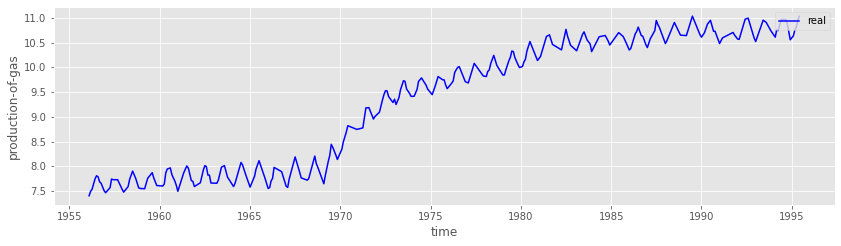

In [7]:
X_orig_second = np.nan_to_num(np.log(production_of_gas_data["production-of-gas"].values + 1))
X_day_second = production_of_gas_data["Date"].values

show_graph(X_day_second, X_orig_second, 'real', ylabel='production-of-gas')

In [8]:
print(X_orig_second.shape)
print(X_orig.shape)

(238,)
(500,)


データの分割
学習データとテストデータに分割し、複数入力に使用可能なように学習データを合わせます。
学習データ
テストデータ

In [9]:
X_train = X_orig[:150]
X_test = X_orig[151:238]
X_train_day = X_day[:150]
X_test_day = X_day[151:238]

X_train_second = X_orig_second[:150]
X_test_second = X_orig_second[151:238]
X_train_day_second = X_day_second[:150]
X_test_day_second = X_day_second[151:238]

学習データ

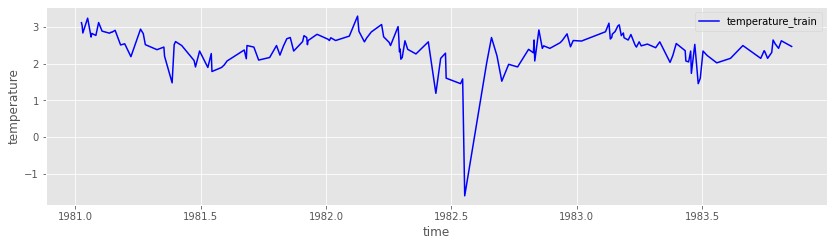

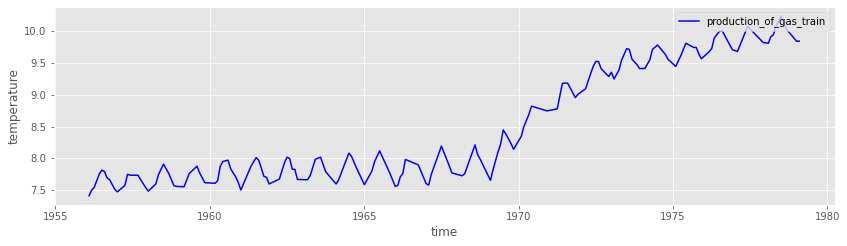

In [10]:
show_graph(X_train_day, X_train, 'temperature_train')
show_graph(X_train_day_second, X_train_second, 'production_of_gas_train')

テストデータ

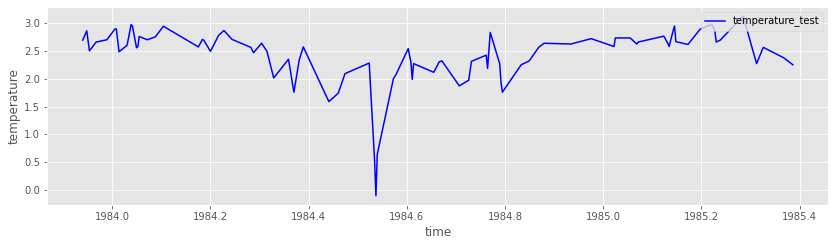

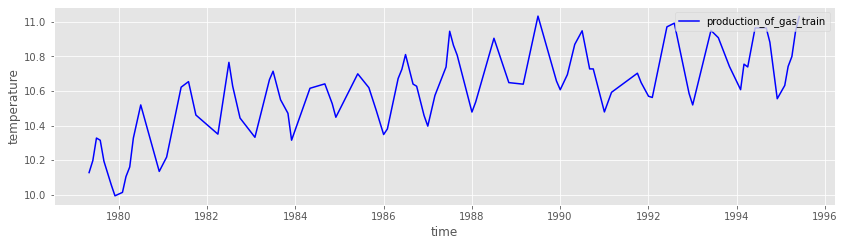

In [11]:
show_graph(X_test_day, X_test, 'temperature_test')
show_graph(X_test_day_second, X_test_second, 'production_of_gas_train')

前処理
get_data: データを前処理して深層学習で扱える形に変換する
transform_data: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [23]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 150)

学習データの正規化及びwindow幅に合わせたデータ設定
学習データを正規化し、window幅に合わせたデータセットに変更します。正規化することで学習が容易になり、window幅は3にしています。

In [25]:
#空の器dataXを作成
#元データの行列数を表示
#
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)


input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)
print('input_dim: ', input_dim)
print('timesteps: ', timesteps)

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
(150, 3, 2)
input_dim:  2
timesteps:  3


In [27]:
x

array([[[0.18780862, 0.67640151],
        [0.3982654 , 0.77892597],
        [0.1556329 , 0.69144581]],

       [[0.3982654 , 0.77892597],
        [0.1556329 , 0.69144581],
        [0.41588131, 0.80095517]],

       [[0.1556329 , 0.69144581],
        [0.41588131, 0.80095517],
        [0.1430136 , 0.72261948]],

       [[0.41588131, 0.80095517],
        [0.1430136 , 0.72261948],
        [0.3801825 , 0.8043866 ]],

       [[0.1430136 , 0.72261948],
        [0.3801825 , 0.8043866 ],
        [0.14808815, 0.70866961]],

       [[0.3801825 , 0.8043866 ],
        [0.14808815, 0.70866961],
        [0.40567748, 0.79324739]],

       [[0.14808815, 0.70866961],
        [0.40567748, 0.79324739],
        [0.16145528, 0.68817951]],

       [[0.40567748, 0.79324739],
        [0.16145528, 0.68817951],
        [0.38068441, 0.77685102]],

       [[0.16145528, 0.68817951],
        [0.38068441, 0.77685102],
        [0.15825735, 0.69521061]],

       [[0.38068441, 0.77685102],
        [0.15825735, 0.6952106

モデルの定義部分
下記でモデルの定義をします。input_dimがデータの入力種類を表しています。今回は2種類のデータなので2が入ります。
モデルの作成
create_modelでモデルを作成しています。指定できるのは
timestepsの幅
ノードの数
自身の状態をリセットするかしないかを指定するstateful(周期的な波形はTrueの方が若干良くなります。)
model_optionでGRUもしくはLSTMを選択できます。
optimizerで設定したいoptimizerを指定できます。デファオルトではadamが入っています。

In [22]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 # データが一つしかないので1しか選べない
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam',
                ):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

定義されたモデルは下記のようになります。1つのモデルで複数の時系列データを扱っているのでLSTMモデルは1つだけになります。

予測関数
モデルの予測部分
モデルが学習した結果を用いて適切に予測できるかを確認します。正規化したデータを元のスケールに戻す処理を入れています。

In [23]:
def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

モデルの学習
モデルの学習
下記のコードでモデルの学習、予測結果の確認を行います。

In [24]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim, 
                     time_steps=time_steps,
                     latent_dim=120,
                     model_option='lstm',
                    )

(150, 3, 2)
input_dim: 2
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 2)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 3, 120)            59040     
_________________________________________________________________
dense (Dense)                (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


In [ ]:
予測結果
テストデータに対する予測結果は下記のようになります。

気温に関する実データ（赤）と予測データ（青）

Epoch 1/400
5/5 [==============================] - 2s 49ms/step - loss: 0.3585 - mse: 0.3585
Epoch 2/400
5/5 [==============================] - 0s 5ms/step - loss: 0.2730 - mse: 0.2730
Epoch 3/400
5/5 [==============================] - 0s 6ms/step - loss: 0.2037 - mse: 0.2037
Epoch 4/400
5/5 [==============================] - 0s 6ms/step - loss: 0.1513 - mse: 0.1513
Epoch 5/400
5/5 [==============================] - 0s 6ms/step - loss: 0.1091 - mse: 0.1091
Epoch 6/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0899 - mse: 0.0899
Epoch 7/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0848 - mse: 0.0848
Epoch 8/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0801 - mse: 0.0801
Epoch 9/400
5/5 [==============================] - 0s 8ms/step - loss: 0.0710 - mse: 0.0710
Epoch 10/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0646 - mse: 0.0646
Epoch 11/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0595

5/5 [==============================] - 0s 6ms/step - loss: 3.9436e-04 - mse: 3.9436e-04
Epoch 170/400
5/5 [==============================] - 0s 7ms/step - loss: 4.2850e-04 - mse: 4.2850e-04
Epoch 171/400
5/5 [==============================] - 0s 8ms/step - loss: 4.4771e-04 - mse: 4.4771e-04
Epoch 172/400
5/5 [==============================] - 0s 8ms/step - loss: 4.1568e-04 - mse: 4.1568e-04
Epoch 173/400
5/5 [==============================] - 0s 8ms/step - loss: 3.5148e-04 - mse: 3.5148e-04
Epoch 174/400
5/5 [==============================] - 0s 7ms/step - loss: 4.4631e-04 - mse: 4.4631e-04
Epoch 175/400
5/5 [==============================] - 0s 8ms/step - loss: 3.3796e-04 - mse: 3.3796e-04
Epoch 176/400
5/5 [==============================] - 0s 6ms/step - loss: 4.2799e-04 - mse: 4.2799e-04
Epoch 177/400
5/5 [==============================] - 0s 7ms/step - loss: 4.3346e-04 - mse: 4.3346e-04
Epoch 178/400
5/5 [==============================] - 0s 6ms/step - loss: 2.8526e-04 - mse: 2.852

5/5 [==============================] - 0s 6ms/step - loss: 1.8786e-04 - mse: 1.8786e-04
Epoch 250/400
5/5 [==============================] - 0s 6ms/step - loss: 1.1415e-04 - mse: 1.1415e-04
Epoch 251/400
5/5 [==============================] - 0s 6ms/step - loss: 1.5498e-04 - mse: 1.5498e-04
Epoch 252/400
5/5 [==============================] - 0s 6ms/step - loss: 1.7203e-04 - mse: 1.7203e-04
Epoch 253/400
5/5 [==============================] - 0s 7ms/step - loss: 1.6738e-04 - mse: 1.6738e-04
Epoch 254/400
5/5 [==============================] - 0s 8ms/step - loss: 2.0222e-04 - mse: 2.0222e-04
Epoch 255/400
5/5 [==============================] - 0s 7ms/step - loss: 1.3284e-04 - mse: 1.3284e-04
Epoch 256/400
5/5 [==============================] - 0s 7ms/step - loss: 1.9731e-04 - mse: 1.9731e-04
Epoch 257/400
5/5 [==============================] - 0s 7ms/step - loss: 1.1483e-04 - mse: 1.1483e-04
Epoch 258/400
5/5 [==============================] - 0s 6ms/step - loss: 1.3112e-04 - mse: 1.311

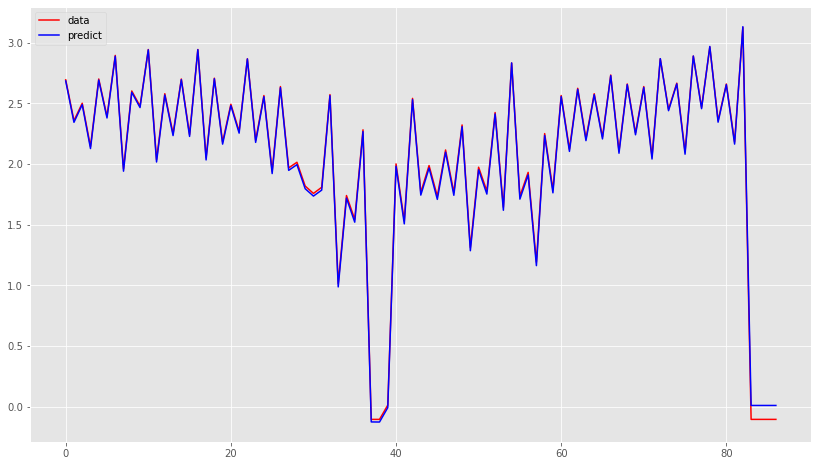

x_scale:  (87, 3, 2)


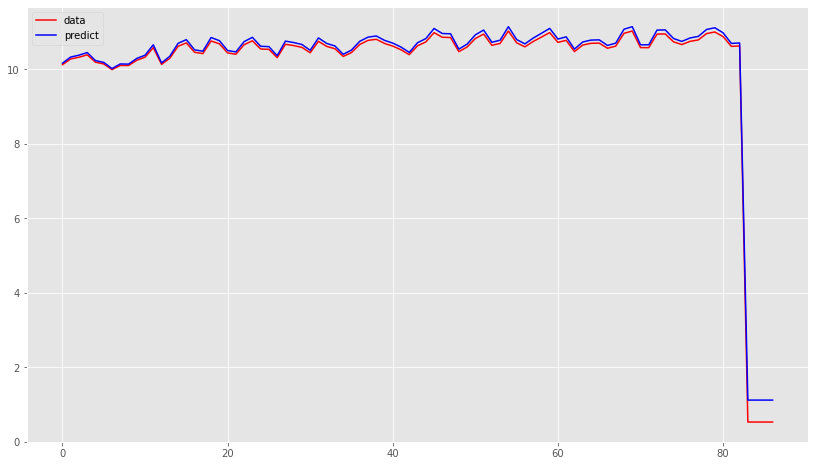

3/3 [==============================] - 1s 3ms/step - loss: 2.7928 - mse: 2.7928
model evaluate mse: [2.792790651321411, 2.7927908897399902]


In [25]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

with timer('train model simple'):
    model.fit(x, x, epochs=400, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

RMSEを計算
実データと予測データの差の指標としてRMSEを用いました。この値が小さいほど精度が高いモデルになります。

値は下記になります。

データ	RMSE
気温	0.0341
ガスの生産量	0.0910

In [26]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.026755152595372436
rmse: 0.08804191275029118
0.057398532672831806


個別入力型モデル
個別入力型の深層学習モデルの組み合わせ モデル定義
コードは下記のようになります。
下記のコードの場合はlist型のデータセットに時系列ごとに設定するLSTMモデルごとのノード数を入れておけば個別に設定が可能になります。時系列ごとにモデルを変更しても構いませんが今回はシンプルにするため、モデルのパラメータのみ変更しています。
定義されたモデルは下記のようになります。時系列ごとにLSTMが用意されていますが全体のモデルとしては1つになります。

In [27]:
def create_model_individual(
     input_dim,
     time_steps,
     latent_dim_list,
     # データが一つしかないので1しか選べない
     batch_size=1,
     model_option='lstm',
     optimizer='adam',
):
    input_list = []
    output_list = []
    
    with tf.name_scope('Model'):
        for i in range(input_dim):
            with tf.name_scope('Input' + str(i)):    
                x = Input(shape=(time_steps, 1,))

            if model_option == 'lstm':
                with tf.name_scope('LSTM' + str(i)):
                    h = LSTM(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            elif model_option == 'gru':
                with tf.name_scope('GRU' + str(i)):
                    h = GRU(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            
            with tf.name_scope('Dense' + str(i)):
                out = Dense(1)(h)
            input_list.append(x)
            output_list.append(out)

        model = Model(inputs=input_list, outputs=output_list)
        model.summary()
        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

個別入力型のためのデータ準備
データの前処理
モデルが異なるので入力するデータのフォーマットが異なります。(2, 150, 3, 1)（データの種類、バッチサイズ、window幅、lstmに入力するデータの種類）のサイズのデータをlist型にして返しています。

In [28]:
def prepare_data_individual(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x_reshape = []
    for i in range(x.shape[0]):
        x_reshape.append([x[i]])
    x_reshape = np.array(x_reshape)
    x_reshape = np.swapaxes(x_reshape, 1, 2)
    x_reshape = np.swapaxes(x_reshape, 2, 3)
    return list(x_reshape), scaler
   

x, scaler = prepare_data_individual(X_train_joint, time_steps, variable_number)
print(len(x))

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
2


In [ ]:
keras2.1.5のバージョンではデータの長さを下記でチェックしており、numpyのarray式でデータを与えるとデータのサイズチェックエラーが発生してしまいます。下記のコードを避けるためにデータの本質は同じですがlist形式にしています。

https://github.com/keras-team/keras/blob/2fae46169239287796d44523deb5e2ac38712ba3/keras/engine/training.py#L78

個別入力型モデルの予測関数

In [29]:
def predict_model_show_graph_individual(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    prepare_value = np.array(prepare_value)
    preds = np.array(preds)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[0]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[i, :, 0, 0], color='r', label='data')
        plt.plot(preds[i, :, 0, 0], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(list(preds), list(prepare_value)))
    return preds, prepare_value
    # return predict_scale, x_scale

個別入力モデルの定義
モデルの学習
モデルの学習に使用したコードは下記になります。時系列ごとのlstmの出力空間の次元を変更しています。

In [30]:
predict_list = []
var_list = []

model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 3, 120)       58560       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 3, 150)       91200       input_3[0][0]                    
____________________________________________________________________________________________

個別入力モデルの学習

Epoch 1/400
5/5 [==============================] - 4s 97ms/step - loss: 0.7791 - dense_1_loss: 0.0588 - dense_2_loss: 0.7203 - dense_1_mse: 0.0588 - dense_2_mse: 0.7203
Epoch 2/400
5/5 [==============================] - 0s 7ms/step - loss: 0.5798 - dense_1_loss: 0.0397 - dense_2_loss: 0.5402 - dense_1_mse: 0.0397 - dense_2_mse: 0.5402
Epoch 3/400
5/5 [==============================] - 0s 9ms/step - loss: 0.4192 - dense_1_loss: 0.0268 - dense_2_loss: 0.3924 - dense_1_mse: 0.0268 - dense_2_mse: 0.3924
Epoch 4/400
5/5 [==============================] - 0s 8ms/step - loss: 0.3019 - dense_1_loss: 0.0209 - dense_2_loss: 0.2811 - dense_1_mse: 0.0209 - dense_2_mse: 0.2811
Epoch 5/400
5/5 [==============================] - 0s 10ms/step - loss: 0.2127 - dense_1_loss: 0.0203 - dense_2_loss: 0.1923 - dense_1_mse: 0.0203 - dense_2_mse: 0.1923
Epoch 6/400
5/5 [==============================] - 0s 8ms/step - loss: 0.1828 - dense_1_loss: 0.0199 - dense_2_loss: 0.1629 - dense_1_mse: 0.0199 - dense_2_ms

5/5 [==============================] - 0s 8ms/step - loss: 0.0025 - dense_1_loss: 9.9848e-06 - dense_2_loss: 0.0025 - dense_1_mse: 9.9848e-06 - dense_2_mse: 0.0025
Epoch 96/400
5/5 [==============================] - 0s 11ms/step - loss: 0.0025 - dense_1_loss: 1.0055e-05 - dense_2_loss: 0.0024 - dense_1_mse: 1.0055e-05 - dense_2_mse: 0.0024
Epoch 97/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0020 - dense_1_loss: 8.5282e-06 - dense_2_loss: 0.0020 - dense_1_mse: 8.5282e-06 - dense_2_mse: 0.0020
Epoch 98/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - dense_1_loss: 8.5385e-06 - dense_2_loss: 0.0021 - dense_1_mse: 8.5385e-06 - dense_2_mse: 0.0021        
Epoch 99/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - dense_1_loss: 8.5100e-06 - dense_2_loss: 0.0019 - dense_1_mse: 8.5100e-06 - dense_2_mse: 0.0019
Epoch 100/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0020 - dense_1_loss: 8.2570e-06 - dense_2_lo

5/5 [==============================] - 0s 9ms/step - loss: 9.4485e-04 - dense_1_loss: 4.2281e-06 - dense_2_loss: 9.4062e-04 - dense_1_mse: 4.2281e-06 - dense_2_mse: 9.4062e-04
Epoch 185/400
5/5 [==============================] - 0s 9ms/step - loss: 0.0011 - dense_1_loss: 4.6664e-06 - dense_2_loss: 0.0011 - dense_1_mse: 4.6664e-06 - dense_2_mse: 0.0011
Epoch 186/400
5/5 [==============================] - 0s 9ms/step - loss: 7.7537e-04 - dense_1_loss: 3.9330e-06 - dense_2_loss: 7.7144e-04 - dense_1_mse: 3.9330e-06 - dense_2_mse: 7.7144e-04
Epoch 187/400
5/5 [==============================] - 0s 6ms/step - loss: 7.7004e-04 - dense_1_loss: 3.8720e-06 - dense_2_loss: 7.6617e-04 - dense_1_mse: 3.8720e-06 - dense_2_mse: 7.6617e-04
Epoch 188/400
5/5 [==============================] - 0s 6ms/step - loss: 8.3803e-04 - dense_1_loss: 4.1736e-06 - dense_2_loss: 8.3386e-04 - dense_1_mse: 4.1736e-06 - dense_2_mse: 8.3386e-04
Epoch 189/400
5/5 [==============================] - 0s 10ms/step - loss: 7.

5/5 [==============================] - 0s 11ms/step - loss: 3.1692e-04 - dense_1_loss: 2.9765e-06 - dense_2_loss: 3.1394e-04 - dense_1_mse: 2.9765e-06 - dense_2_mse: 3.1394e-04
Epoch 268/400
5/5 [==============================] - 0s 7ms/step - loss: 2.7118e-04 - dense_1_loss: 2.7110e-06 - dense_2_loss: 2.6847e-04 - dense_1_mse: 2.7110e-06 - dense_2_mse: 2.6847e-04
Epoch 269/400
5/5 [==============================] - 0s 7ms/step - loss: 3.0406e-04 - dense_1_loss: 2.5587e-06 - dense_2_loss: 3.0151e-04 - dense_1_mse: 2.5587e-06 - dense_2_mse: 3.0151e-04
Epoch 270/400
5/5 [==============================] - 0s 6ms/step - loss: 2.5199e-04 - dense_1_loss: 2.9406e-06 - dense_2_loss: 2.4905e-04 - dense_1_mse: 2.9406e-06 - dense_2_mse: 2.4905e-04
Epoch 271/400
5/5 [==============================] - 0s 12ms/step - loss: 2.2443e-04 - dense_1_loss: 2.8988e-06 - dense_2_loss: 2.2153e-04 - dense_1_mse: 2.8988e-06 - dense_2_mse: 2.2153e-04
Epoch 272/400
5/5 [==============================] - 0s 12ms/s

Epoch 310/400
5/5 [==============================] - 0s 11ms/step - loss: 1.1830e-04 - dense_1_loss: 2.2737e-06 - dense_2_loss: 1.1603e-04 - dense_1_mse: 2.2737e-06 - dense_2_mse: 1.1603e-04
Epoch 311/400
5/5 [==============================] - 0s 10ms/step - loss: 6.9757e-05 - dense_1_loss: 2.0769e-06 - dense_2_loss: 6.7680e-05 - dense_1_mse: 2.0769e-06 - dense_2_mse: 6.7680e-05
Epoch 312/400
5/5 [==============================] - 0s 7ms/step - loss: 1.5401e-04 - dense_1_loss: 2.2288e-06 - dense_2_loss: 1.5178e-04 - dense_1_mse: 2.2288e-06 - dense_2_mse: 1.5178e-04
Epoch 313/400
5/5 [==============================] - 0s 6ms/step - loss: 7.9954e-05 - dense_1_loss: 2.1978e-06 - dense_2_loss: 7.7756e-05 - dense_1_mse: 2.1978e-06 - dense_2_mse: 7.7756e-05
Epoch 314/400
5/5 [==============================] - 0s 6ms/step - loss: 1.0803e-04 - dense_1_loss: 2.1263e-06 - dense_2_loss: 1.0590e-04 - dense_1_mse: 2.1263e-06 - dense_2_mse: 1.0590e-04
Epoch 315/400
5/5 [=============================

5/5 [==============================] - 0s 6ms/step - loss: 5.5341e-05 - dense_1_loss: 1.8773e-06 - dense_2_loss: 5.3464e-05 - dense_1_mse: 1.8773e-06 - dense_2_mse: 5.3464e-05
Epoch 354/400
5/5 [==============================] - 0s 6ms/step - loss: 5.0851e-05 - dense_1_loss: 1.8325e-06 - dense_2_loss: 4.9018e-05 - dense_1_mse: 1.8325e-06 - dense_2_mse: 4.9018e-05
Epoch 355/400
5/5 [==============================] - 0s 10ms/step - loss: 8.0594e-05 - dense_1_loss: 1.6563e-06 - dense_2_loss: 7.8938e-05 - dense_1_mse: 1.6563e-06 - dense_2_mse: 7.8938e-05
Epoch 356/400
5/5 [==============================] - 0s 12ms/step - loss: 6.0222e-05 - dense_1_loss: 1.8742e-06 - dense_2_loss: 5.8347e-05 - dense_1_mse: 1.8742e-06 - dense_2_mse: 5.8347e-05
Epoch 357/400
5/5 [==============================] - 0s 11ms/step - loss: 3.9982e-05 - dense_1_loss: 1.7212e-06 - dense_2_loss: 3.8261e-05 - dense_1_mse: 1.7212e-06 - dense_2_mse: 3.8261e-05
Epoch 358/400
5/5 [==============================] - 0s 11ms/

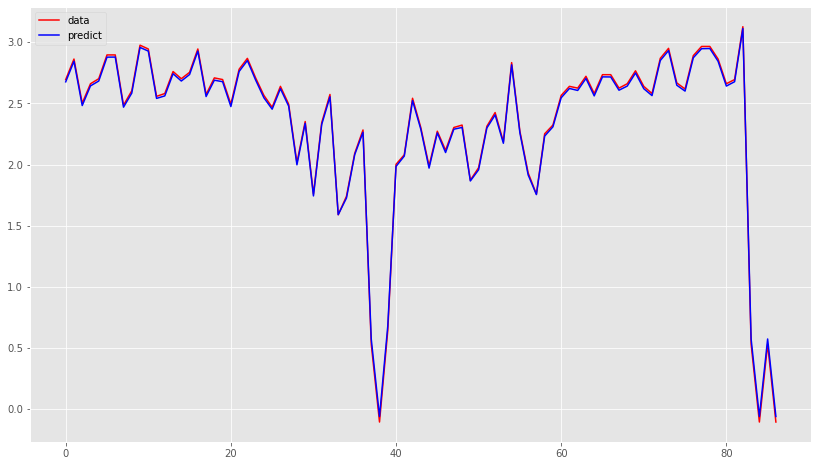

x_scale:  (2, 87, 3, 1)


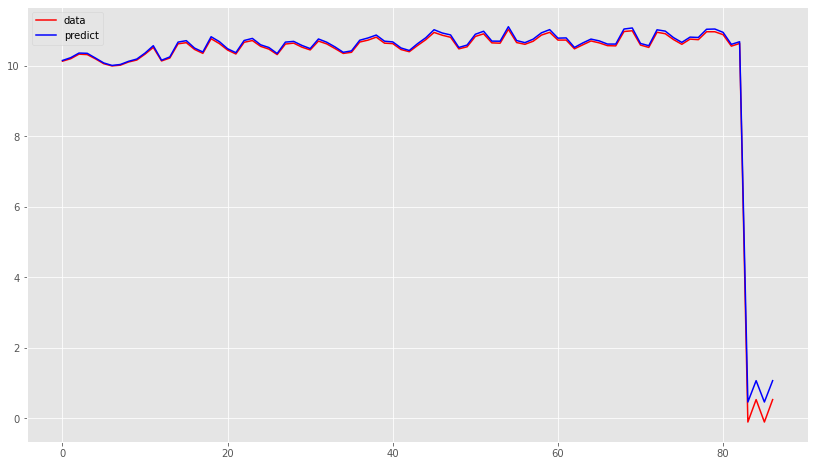

3/3 [==============================] - 1s 4ms/step - loss: 1.5533 - dense_1_loss: 0.0825 - dense_2_loss: 1.4708 - dense_1_mse: 0.0825 - dense_2_mse: 1.4708
model evaluate mse: [1.5532951354980469, 0.08250238746404648, 1.4707927703857422, 0.08250238746404648, 1.4707927703857422]


In [31]:
log_dir = 'model_individual'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

with timer('train model individual'):
    model.fit(x, x, epochs=400, callbacks=[tensorboard])

window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

精度の評価

In [32]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.015905191283403224
rmse: 0.07658227994131232
0.04624373561235777
